The Hough transform is a technique which can be used to isolate features of a particular shape within an image. It was originally proposed to detect lines [Richard&Peter, 1971](http://www.ai.sri.com/pubs/files/tn036-duda71.pdf).

Tutorials:
1. [Hough Transform](http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm)
2. [Colorado School of Mines, Hough transform](https://inside.mines.edu/~whoff/courses/EENG512/lectures/13-Hough.pdf)
3. [Understanding Hough Transform With Python](https://alyssaq.github.io/2014/understanding-hough-transform/)
4. [Generalize Hough transform to detect arbitrary shapes](http://www.eng.tau.ac.il/~cvapps/Supplement/%5B%201981%20%5D%20Generalizing%20the%20Hough%20Transform%20to%20Detect%20Arbitrary%20Shapes.pdf)

# Normal form / polar coordinate representation of a line
The normal paramters for a line are illustrated below
![image](./img/line_normal_form.png)
Supposing the line is neither vertical nor horizontal, i.e., the two intercepts are both non-zero, then the slope-intercept representation of the line is 
\begin{equation}
y = kx + b = -\frac{y_0}{x_0}x + y_0
\end{equation}
From the above figure, where the distance $\rho\ge 0$ and the angle $\theta\in[0, 2\pi)$, it is easy to obtain taht 
\begin{equation}
cos\theta=\frac{\rho}{x_0}, \quad, sin\theta=\frac{\rho}{y_0}.
\end{equation}
Now replacing $x_0$ and $y_0$ with the correponding expression using $\rho$ and $\theta$, we can get 
\begin{equation}
\rho = xcos\theta + ysin\theta.
\end{equation}
What's more, it is also straightforward to verify that the above equation holds even when the slope is infinite (vertical line) or the line is horizontal. It is called the **normal form or polar coordinate representation** of a straight line in 2D space.

*Intercept form to normal form*  
From the above equation (2), we have 
\begin{equation}
\rho^2 = \frac{x_0^2 y_0^2}{x_0^2 + y_0^2}.
\end{equation}
After we get $\rho$, it is straightforward to get the angle $\theta$.

*Why do we use the normal form?*  
Because the slope-intercept form can not handle the special case when the line is vertical.

# Hough transform of lines
For each line in the 2D coordinate, it correponds to a single point $(\theta, \rho)$ in the parameter space. On the handle, given a single point $p1=(x_1, y_1)$ in the 2D coordinate (or call it image space if we are processing an image), all the possible lines passing through this point are transformed into the parameter space by 
\begin{equation}
\rho = x_1 cos\theta + y_1 sin\theta.
\end{equation}
Using some trigonometry knowledge, we can show that the above equation actually depicts a sinusoidal curve $s_1$ in the parameter space.

If we have another point in the original 2D space, $p2=(x_2, y_2)$, then similarly it will yield another sinusoid $s_2$ in the parameter space. More importantly, consider the straight line $l_{12}$ passing through the two points, and it is obvious that $l_{12}$ is also characterized by a pair of unique parameters $(\theta_{12}, \rho_{12})$, which should be the common point of $s_1$ and $s_2$. This conclusion can be generalized to any number of points on a single line in the 2D coordinate image space.

In other words, if there are multiple points $p_i, i=1,2,\cdots,m$ on the same line in the image space, then there must exist a certain $\theta^*$ such that $\rho^* = x_i cos\theta^* + y_i sin\theta^*$ yields the same value for all $i$. And in the parameter space, such a point $(\theta^*, \rho^*)$ is just the intersection point of all the $m$ sinusoids in the parameter space.

However, in reality, these points, like pixels on an image, are usually corrupted by noise, which means in most cases not all the $m$ points give the same $\rho$ value for the ideal $\theta^*$. However, we can be sure that all the generated $\rho$ values should be quite close for the $\theta^*$, which is assumed to be known for now. Now the question is that $\theta^*$ is unknown. 

Fortunately, since $\theta$ is bounded, we can test each possible value. Of course, in practice, we have to discretize $\theta$ to a finite set of values to be examined. Similarly, the value of $\rho$ is also binned. Now by quantizing the Hough parameter space into finite intervals, we get the so-called *accumulator cell array*. 

**Algorithm**
- Initialize the 2D cell array H by quantizing $\theta$ and $\rho$ in a specified range into proper intervals.
- For each point $(x_i, y_i)$
    - For each discretized $\theta$ value, compute the corresponding $\rho = x_i cos\theta + y_i sin\theta$.
    - Increment (add 1 to) the cell in H corresponding to $(\theta, \rho)$, known as *Voting in the accumulator*
- Find the local maxima with most votes according to certain criteria, which are concluded as the lines in the original image space.

![image](./img/hough-line.png)

## Range of $\theta$ and $\rho$
In actual implementation, for simplicity and speed, we usually choose the range of the angle $\theta$ as $[0^\circ, 180^\circ)$, while the algebraic distance $\rho$ can be negative in this case. If $\rho$ is negative, it simply means we should use the perpendicular distance in the opposite direction.  
Regaring $\rho$, its range is defined according prior knowledge. For example, in image processing, the maximum possible value of $\rho$ is the length of the diagonal.
![image](./img/negative-rho.png)
In libraries such as MATLAB and opencv, they may have different definitions of the range of $\theta$. However, they are actually equivalent.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# A Toy Example for Line Detection
In real image processing, the firs step is usually edge detection.  The resultant binary/grey image will have 0s indicating non-edges and 1s or above indicating edges. However, here for simplicity, supposing we have three lines to be detected, 7, 8, 9 points are present for each line respectively. Our task is to adopt Hough transform to find these three lines from all the points.

Three lines in two-intercept form:
\begin{align}
x + y &= 1 \\
\frac{x}{5} + \frac{y}{-3} &= 1 \\
\frac{x}{-8} + \frac{y}{6} &= 1
\end{align}

Let's first assume we know the lines exactly, and compute the corresponding $(\theta, \rho)$ parameters.
### Ground truth

In [25]:
import numpy as np
def compute_polar_parameters(x0, y0):
    """
    @param x0 array of x-axis intersects
    @param array of y-axis intersects
    @return theta (in degrees) and rho (non-negative)
    """
    rho = np.sqrt((x0**2 * y0**2) / (x0**2 + y0**2))
    theta = np.arccos(rho / x0)
    # np.arccos --> [0, pi]. Now turn it into [0, 2pi]
    theta = theta + (y0 < 0) * np.pi
    return np.rad2deg(theta), rho

In [26]:
x0 = np.array([1, 5, -8])
y0 = np.array([1, -3, 6])
theta, rho = compute_polar_parameters(x0, y0)
print('theta (degree): ', theta)
print('rho: ', rho)

theta (degree):  [ 45.         239.03624347 126.86989765]
rho:  [0.70710678 2.57247878 4.8       ]


### Generate data points
 7, 8, 9 points for three lines respectively, with no noise and $x\in[-20, 20]$.
 \begin{equation}
 \frac{x}{x_0} + \frac{y}{y_0} = 1 \Rightarrow y = -\frac{y_0}{x_0}x + y_0
 \end{equation}

In [27]:
np.random.seed(213)
x_list = []
y_list = []
for i, n in enumerate([7, 8, 9]):
    xi = np.random.randint(-20, 21, n)
    yi = -y0[i] / x0[i] * xi + y0[i]  # ith line
    x_list.append(xi)
    y_list.append(yi)
# concatenate the x and y arrays into single ones: xi and yi are both 1d arrays
x = np.hstack(x_list)
y = np.hstack(y_list)
print(x.shape, y.shape)

(24,) (24,)


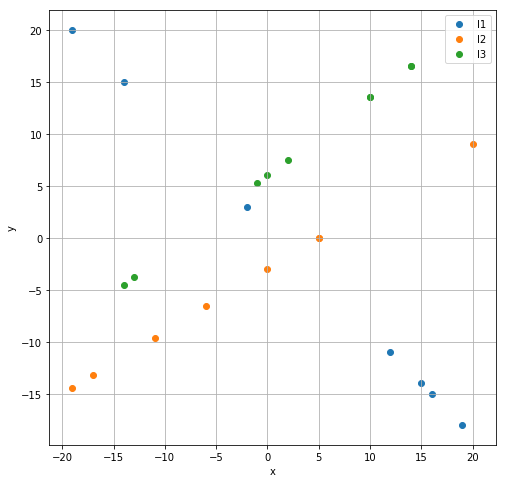

In [28]:
# visualization
fig = plt.figure(figsize=(8, 8))
for xi, yi in zip(x_list, y_list):
    plt.scatter(x, y)
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['l1', 'l2', 'l3'])

### Line detection with Hough transform


Besides, we know that since the range for both axes is $[-20, 20]$, the maximum possible $\rho$ is about 28, i.e., $\rho\in[-28, 28]$. Let's discretize the two parameters with resolution 1.
#### （1） Initialize the accumulator array
Let rows denote $\rho$ and columns denote $\theta$. Then, we need a 2D array, or *accumulator*, of size $(29, 

In [31]:
acc = np.zeros((360, 29), dtype=np.int)

#### (2) Voting
For each point and each quantized $\theta$ value, compute $\rho$ and increment the value of the bin at $(\theta, \rho)$ by one. The value represents the number of votes. 

In [39]:
for xp, yp in zip(x, y):
    for theta in range(0, 360):
        rho = xp * np.cos(theta) + yp * np.sin(theta)
        # turn rho into an integer to find the correponding position in accumulator array
        rho = np.rint(rho).item()
        if rho > 28:
            rho = 28
        # increment
        print(theta, rho)
        acc[theta, rho] += 1

0 -14.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices